# IMPORTS

In [1]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import trim_mean
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
from scipy.stats import zscore

# •	Carregar e ler arquivos .csv, xlsx ou de um banco de dados;

In [2]:
file_path = r"Real_Estate_Sales_2001-2021_GL.csv"

# Specify data types to avoid warnings
dtype_specs = {
    'Serial Number': str,
    'List Year': str,
    'Town': str,
    'Address': str,
    'Assessed Value': float,
    'Sale Amount': float,
    'Sales Ratio': float,
    'Property Type': str,
    'Non Use Code': 'category',
    'Assessor Remarks': 'category',
    'OPM remarks': 'category',
    'Location': 'category'
}

# Load the data with dtype specification and low_memory=False to avoid DtypeWarning
df = pd.read_csv(file_path, dtype=dtype_specs, low_memory=False)

# •	Avaliar a necessidade da transformação da variável em outra escala (agrupar idade por faixas, por exemplo);

# TRATAMENTO DOS DADOS

In [3]:
# Date conversion and text normalization
df['Date Recorded'] = pd.to_datetime(df['Date Recorded'], format='%m/%d/%Y', errors='coerce')
df['Town'] = df['Town'].str.title()
df['Address'] = df['Address'].str.title()

# Impute missing values in numeric columns with the median
for column in ['Assessed Value', 'Sale Amount', 'Sales Ratio']:#
    median_value = df[column].median()#
    df[column].fillna(median_value, inplace=True)#

# Impute missing values in categories with the mode
for column in ['Non Use Code', 'Assessor Remarks', 'OPM remarks', 'Location']:#
    mode_value = df[column].mode()[0]#
    df[column].fillna(mode_value, inplace=True)#
    
# Drop specified columns#
df = df.drop(['Location', 'Non Use Code', 'OPM remarks', 'Assessor Remarks'], axis=1)#

# Adding the month column and handling possible nulls in dates
df['Month'] = df['Date Recorded'].dt.month.fillna(df['Date Recorded'].dt.month.mode()[0])#

# Calculating the profit margin and handling divisions by zero #
df['Profit Margin (%)'] = ((df['Sale Amount'] - df['Assessed Value']) / df['Sale Amount']).replace([float('inf'), -float('inf')], 0) * 100

# Drop rows where 'Profit Margin (%)' is null#
df.dropna(subset=['Profit Margin (%)'], inplace=True)

# Count sales by address and town
sales_count = df.groupby(['Town', 'Address']).size().reset_index(name='Sales Count')

# Total sales by town
total_sales_by_town = sales_count.groupby('Town')['Sales Count'].sum().reset_index(name='Total Sales by Town')

# Merge counts with totals to calculate proportions
sales_count = sales_count.merge(total_sales_by_town, on='Town')
sales_count['Proportion (%)'] = (sales_count['Sales Count'] / sales_count['Total Sales by Town']) * 100

# Classify addresses based on proportion
def classify_proportion_numeric(x):
    if (x > 5):
        return 2  # High Proportion
    elif (x >= 1) and (x <= 5):
        return 1  # Medium Proportion
    else:
        return 0  # Low Proportion

# Aplicar a função para criar uma nova coluna com as categorias numéricas
sales_count['Sales Status Numeric'] = sales_count['Proportion (%)'].apply(classify_proportion_numeric)

# Incorporating the status back into the original DataFrame for complete analysis
df = df.merge(sales_count[['Town', 'Address']], on=['Town', 'Address'], how='left')

# Calculation of city ranking by total sales amount
town_sales_total = df.groupby('Town')['Sale Amount'].sum().reset_index(name='Total Sales Amount')
town_sales_total['Rank'] = town_sales_total['Total Sales Amount'].rank(ascending=False).astype(int)

# Incorporate ranking into DataFrame
df = df.merge(town_sales_total[['Town', 'Rank']], on='Town', how='left')

# Rename columns to remove spaces
df.columns = [col.replace(' ', '_') for col in df.columns]
# Preencher valores nulos em 'Property_Type' com a moda
mode_property_type = df['Property_Type'].mode()[0]
df['Property_Type'].fillna(mode_property_type, inplace=True)
# Preencher valores nulos em 'Residential_Type' com a moda
mode_residential_type = df['Residential_Type'].mode()[0]
df['Residential_Type'].fillna(mode_residential_type, inplace=True)


# •	Realizar a codificação das variáveis categóricas de acordo com os valores das variáveis (label encoder, one hot encoder ou target encoder);

In [4]:
# Tratar variáveis categóricas
label_encoders = {}
categorical_cols = ['Town', 'Address', 'Month']
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

df

,Serial_Number,List_Year,Date_Recorded,Town,Address,Assessed_Value,Sale_Amount,Sales_Ratio,Property_Type,Residential_Type,Month,Profit_Margin_(%),Rank
0,2020348,2020,2021-09-13,2,279732,150500.0,325000.0,0.463000,Commercial,Single Family,8,53.692308,97
1,20002,2020,2020-10-02,3,440044,253000.0,430000.0,0.588300,Residential,Single Family,9,41.162791,150
2,210317,2021,2022-07-05,4,539077,329730.0,805000.0,0.409600,Residential,Single Family,6,59.039752,30
3,200212,2020,2021-03-09,4,513316,130400.0,179900.0,0.724800,Residential,Condo,2,27.515286,30
4,200243,2020,2021-04-13,4,54305,619290.0,890000.0,0.695800,Residential,Single Family,3,30.416854,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1053867,190272,2019,2020-06-24,94,443123,60410.0,53100.0,1.137665,Single Family,Single Family,5,-13.766478,65
1053868,190284,2019,2019-11-27,151,89848,68280.0,76000.0,0.898400,Single Family,Single Family,10,10.157895,15
1053869,190129,2019,2020-04-27,165,211262,121450.0,210000.0,0.578300,Single Family,Single Family,3,42.166667,85
1053870,190504,2019,2020-06-03,83,662214,203360.0,280000.0,0.726300,Single Family,Single Family,5,27.371429,31


In [5]:
#tratando as colunas no padrao one hot encoder 
df = pd.get_dummies(df, columns=['Property_Type', 'Residential_Type'])
df

,Serial_Number,List_Year,Date_Recorded,Town,Address,Assessed_Value,Sale_Amount,Sales_Ratio,Month,Profit_Margin_(%),...,Property_Type_Residential,Property_Type_Single Family,Property_Type_Three Family,Property_Type_Two Family,Property_Type_Vacant Land,Residential_Type_Condo,Residential_Type_Four Family,Residential_Type_Single Family,Residential_Type_Three Family,Residential_Type_Two Family
0,2020348,2020,2021-09-13,2,279732,150500.0,325000.0,0.463000,8,53.692308,...,0,0,0,0,0,0,0,1,0,0
1,20002,2020,2020-10-02,3,440044,253000.0,430000.0,0.588300,9,41.162791,...,1,0,0,0,0,0,0,1,0,0
2,210317,2021,2022-07-05,4,539077,329730.0,805000.0,0.409600,6,59.039752,...,1,0,0,0,0,0,0,1,0,0
3,200212,2020,2021-03-09,4,513316,130400.0,179900.0,0.724800,2,27.515286,...,1,0,0,0,0,1,0,0,0,0
4,200243,2020,2021-04-13,4,54305,619290.0,890000.0,0.695800,3,30.416854,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1053867,190272,2019,2020-06-24,94,443123,60410.0,53100.0,1.137665,5,-13.766478,...,0,1,0,0,0,0,0,1,0,0
1053868,190284,2019,2019-11-27,151,89848,68280.0,76000.0,0.898400,10,10.157895,...,0,1,0,0,0,0,0,1,0,0
1053869,190129,2019,2020-04-27,165,211262,121450.0,210000.0,0.578300,3,42.166667,...,0,1,0,0,0,0,0,1,0,0
1053870,190504,2019,2020-06-03,83,662214,203360.0,280000.0,0.726300,5,27.371429,...,0,1,0,0,0,0,0,1,0,0


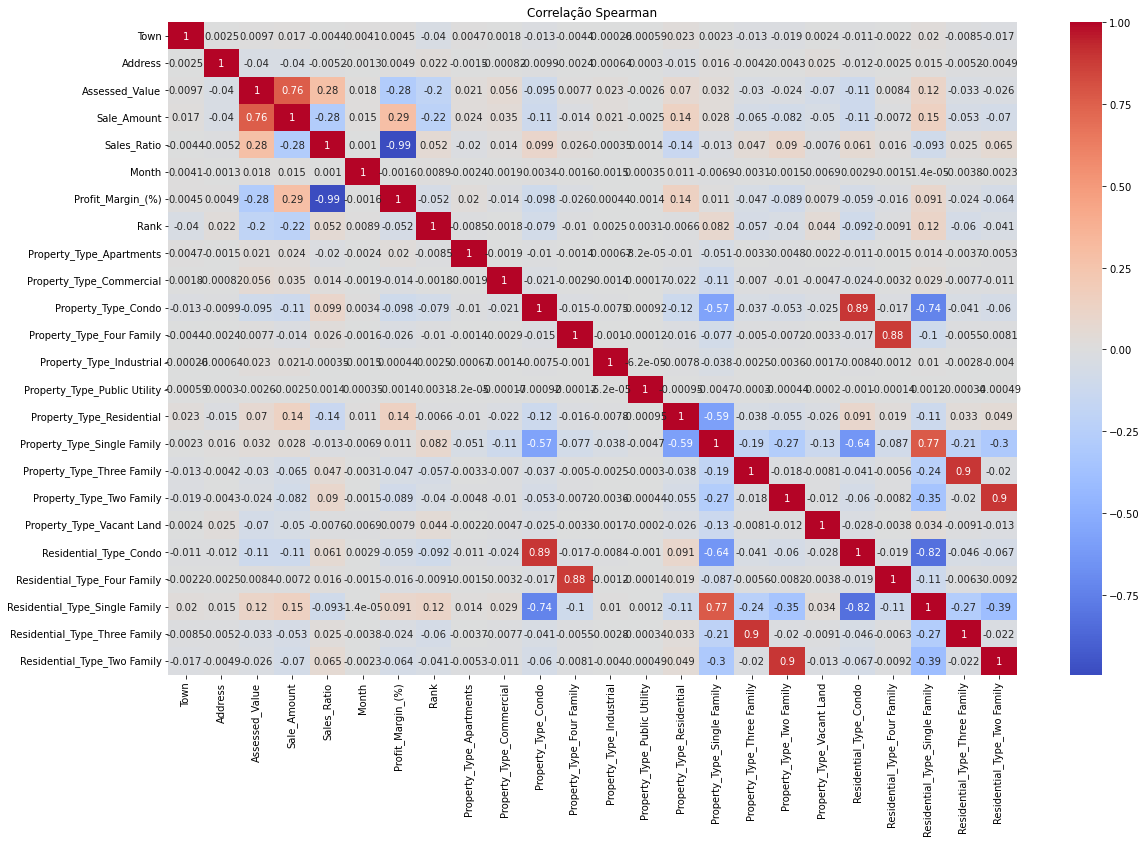

In [6]:
#correlacao usando spearman 
corr_matrix = df.corr(method='spearman')

#mapa de calor
plt.figure(figsize=(19, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlação Spearman')
plt.show()

In [7]:
df['Month'] = df['Month'] + 1 

# •	Avaliar a necessidade de realizar o balanceamento da variável alvo;
# MINI ANALISE EXPLORATORIA

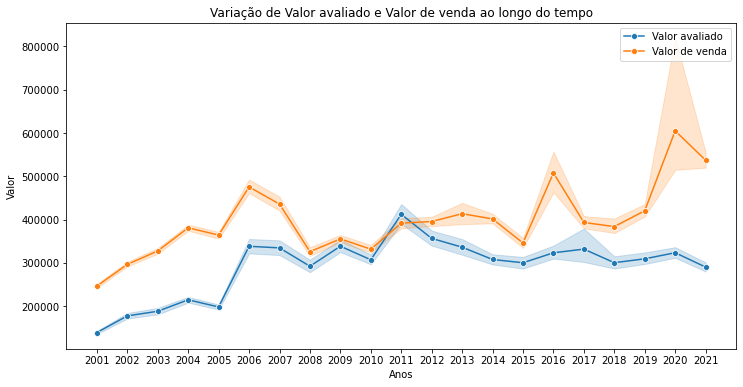

In [8]:
df_grafico_valor_ano = df[['List_Year','Assessed_Value', 'Sale_Amount']]
df_grafico_valor_ano = df_grafico_valor_ano.sort_values(ascending=True,by='List_Year')

plt.figure(figsize=(12, 6))
sns.lineplot(x='List_Year', y='Assessed_Value', data=df_grafico_valor_ano, marker='o', label='Valor avaliado')
sns.lineplot(x='List_Year', y='Sale_Amount', data=df_grafico_valor_ano, marker='o', label='Valor de venda')
plt.title('Variação de Valor avaliado e Valor de venda ao longo do tempo')
plt.xlabel('Anos')
plt.ylabel('Valor')
plt.legend()
plt.show()

- Ver o que é essa borda em amarelo ( variação max e min em relação ao ponto vs extremidades)

# Mas podemos perceber ao decorrer de 21 anos segue-se o padrão do valor vendido ser maior que o valor avaliado, menos em 2011. Portanto, é bem provavel que padrão vai seguir ao decorrer dos anos.
### causas:
- Disputa entre compradores 
- Demora da compra e consequentemente a valorização do bem

C:\Users\Wellington\AppData\Local\Temp\ipykernel_1368\513817050.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(quarterly_data['Quarter'], rotation=45)
C:\Users\Wellington\AppData\Local\Temp\ipykernel_1368\513817050.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(quarterly_data['Quarter'], rotation=45)
C:\Users\Wellington\AppData\Local\Temp\ipykernel_1368\513817050.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(quarterly_data['Quarter'], rotation=45)


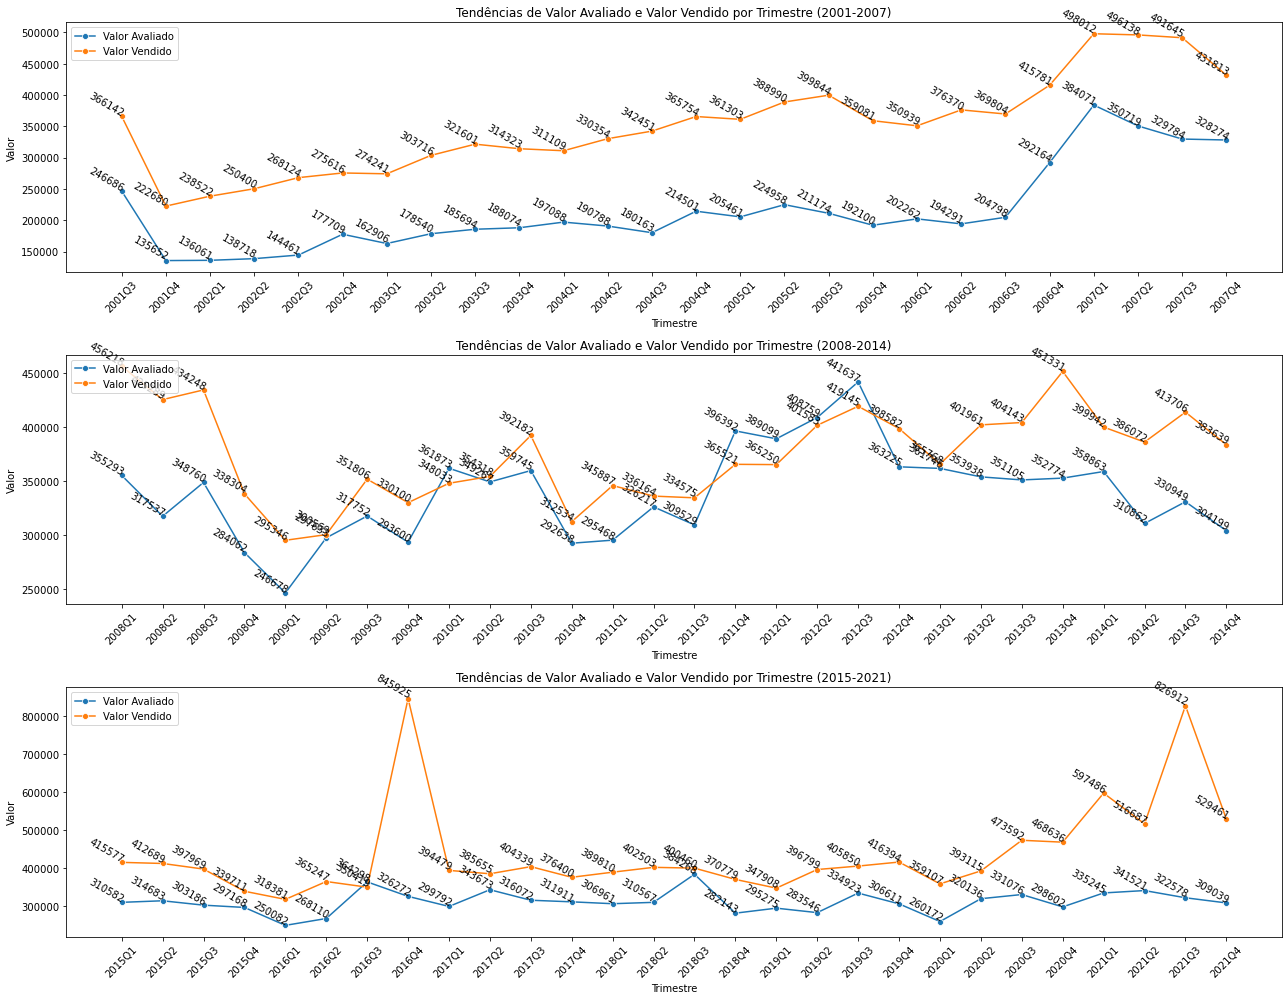

In [9]:
df_grafico_valor_mes = df[['Date_Recorded','Assessed_Value', 'Sale_Amount']]
df_grafico_valor_mes = df_grafico_valor_mes.sort_values(ascending=True,by='Date_Recorded')

# manipulando para criar trimestre 
df_grafico_valor_mes['Year'] = df_grafico_valor_mes['Date_Recorded'].dt.year
df_grafico_valor_mes['Month'] = df_grafico_valor_mes['Date_Recorded'].dt.month
df_grafico_valor_mes['Quarter'] = df_grafico_valor_mes['Date_Recorded'].dt.to_period('Q').astype(str)
angle = -30


intervalos = [(2001, 2007), (2008, 2014), (2015, 2021)]

# grafico por intervalo
plt.figure(figsize=(18, 14))

for i, (start_year, end_year) in enumerate(intervalos):
    interval_df = df_grafico_valor_mes[(df_grafico_valor_mes['Year'] >= start_year) & (df_grafico_valor_mes['Year'] <= end_year)]
    quarterly_data = interval_df.groupby('Quarter').agg({'Assessed_Value': 'mean', 'Sale_Amount': 'mean'}).reset_index()
    
    ax = plt.subplot(3, 1, i + 1)
    sns.lineplot(x='Quarter', y='Assessed_Value', data=quarterly_data, marker='o', label='Valor Avaliado', ax=ax)
    sns.lineplot(x='Quarter', y='Sale_Amount', data=quarterly_data, marker='o', label='Valor Vendido', ax=ax)
    
    # adicionar valor dentro do grafico
    for line in ax.lines:
        for x, y in zip(line.get_xdata(), line.get_ydata()):
            ax.text(x, y, f'{y:.0f}', color= 'k', ha="right", rotation=angle, rotation_mode='anchor')

    ax.set_title(f'Tendências de Valor Avaliado e Valor Vendido por Trimestre ({start_year}-{end_year})')
    ax.set_xlabel('Trimestre')
    ax.set_ylabel('Valor')
    ax.legend(loc='upper left')
    ax.set_xticklabels(quarterly_data['Quarter'], rotation=45)

plt.tight_layout()
plt.show()

- dados brutos após o tratamento
# O padrão segue o mesmo entre o período do terceiro trimestre de 2001 até o primeiro trimestre de 2009. A partir do segundo trimestre de 2009 até o primeiro trimestre de 2013 há variações entre o valor avaliado e o valor vendio, porém a partir do segundo trimestre de 2013 volta ao padrão com exceção do terceiro trimestre de 2016

### Causas para a fuga do padrão entre o primeiro trimestre de 2009 e o primeiro trimestre de 2013:
- provavelmente outliers, mas não sei as causas dos outliers.

C:\Users\Wellington\AppData\Local\Temp\ipykernel_1368\3759777305.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(quarterly_data['Quarter'], rotation=45)
C:\Users\Wellington\AppData\Local\Temp\ipykernel_1368\3759777305.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(quarterly_data['Quarter'], rotation=45)
C:\Users\Wellington\AppData\Local\Temp\ipykernel_1368\3759777305.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(quarterly_data['Quarter'], rotation=45)


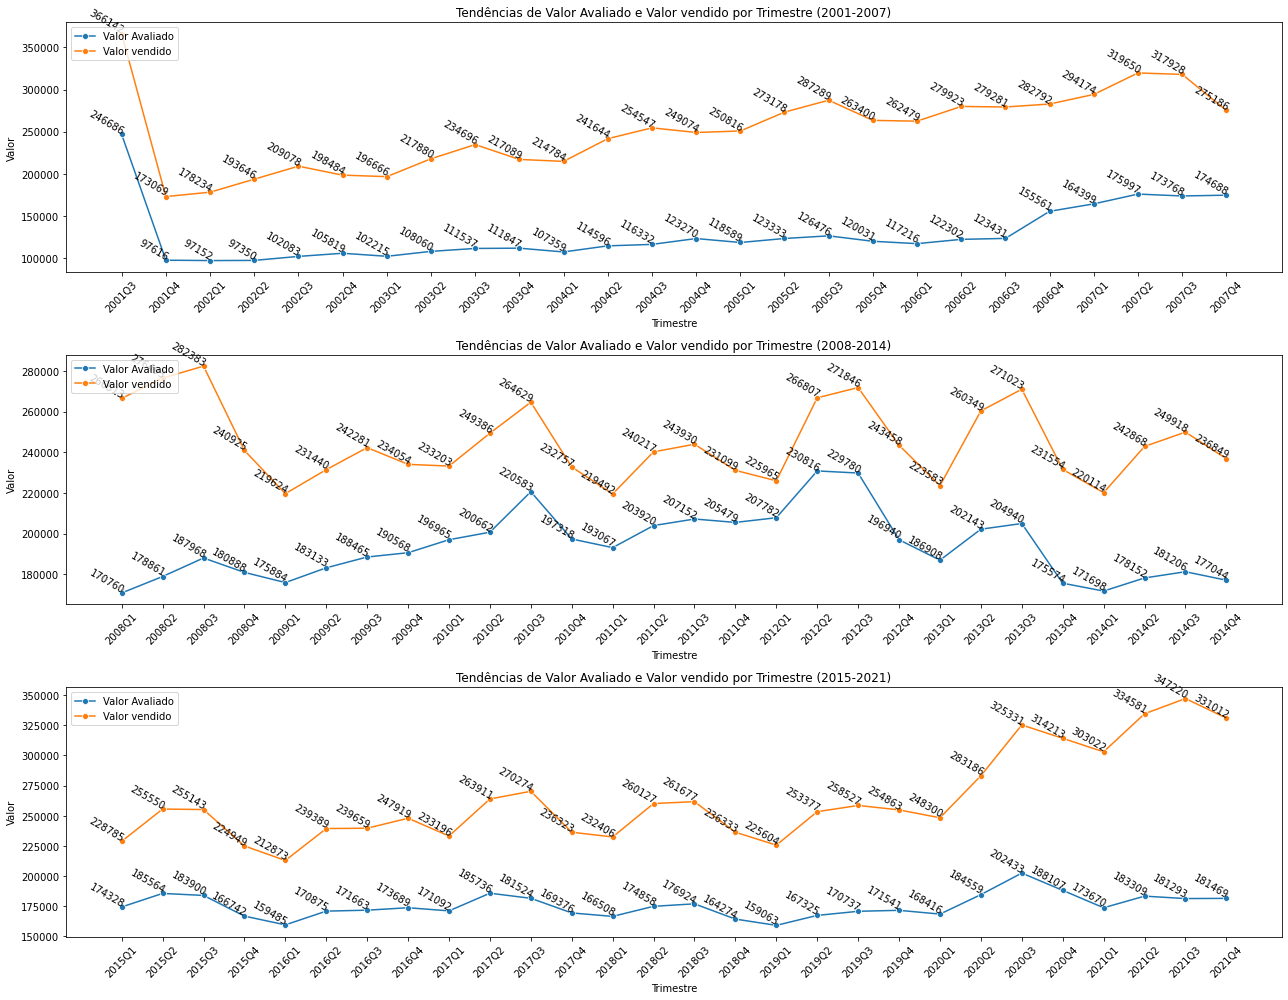

In [10]:
df_grafico_valor_mes = df[['Date_Recorded','Assessed_Value', 'Sale_Amount']]
df_grafico_valor_mes = df_grafico_valor_mes.sort_values(ascending=True,by='Date_Recorded')

# Criar colunas de Ano, Mês e Trimestre
df_grafico_valor_mes['Year'] = df_grafico_valor_mes['Date_Recorded'].dt.year
df_grafico_valor_mes['Month'] = df_grafico_valor_mes['Date_Recorded'].dt.month
df_grafico_valor_mes['Quarter'] = df_grafico_valor_mes['Date_Recorded'].dt.to_period('Q').astype(str)
angle = -30

intervalos = [(2001, 2007), (2008, 2014), (2015, 2021)]


# Função para calcular a média aparada
def trimmed_mean(series, proportion_to_cut=0.1):
    return trim_mean(series, proportion_to_cut)

# Dividir o DataFrame em intervalos de anos
intervalos = [(2001, 2007), (2008, 2014), (2015, 2021)]

# grafico por intervalo
plt.figure(figsize=(18, 14))

for i, (start_year, end_year) in enumerate(intervalos):
    interval_df = df_grafico_valor_mes[(df_grafico_valor_mes['Year'] >= start_year) & (df_grafico_valor_mes['Year'] <= end_year)]
    quarterly_data = interval_df.groupby('Quarter').agg({
        'Assessed_Value': lambda x: trimmed_mean(x, 0.1),
        'Sale_Amount': lambda x: trimmed_mean(x, 0.1)
    }).reset_index()
    
    ax = plt.subplot(3, 1, i + 1)
    sns.lineplot(x='Quarter', y='Assessed_Value', data=quarterly_data, marker='o', label='Valor Avaliado', ax=ax)
    sns.lineplot(x='Quarter', y='Sale_Amount', data=quarterly_data, marker='o', label='Valor vendido', ax=ax)
    
    # adicionar valor dentro do grafico
    for line in ax.lines:
        for x, y in zip(line.get_xdata(), line.get_ydata()):
            ax.text(x, y, f'{y:.0f}', color='k', ha="right",rotation=angle, rotation_mode='anchor')

    ax.set_title(f'Tendências de Valor Avaliado e Valor vendido por Trimestre ({start_year}-{end_year})')
    ax.set_xlabel('Trimestre')
    ax.set_ylabel('Valor')
    ax.legend(loc='upper left')
    ax.set_xticklabels(quarterly_data['Quarter'], rotation=45)

plt.tight_layout()
plt.show()

- Utilizando média aparada(10%) para deixar a linha menos sensivel aos outliers

# O padrão em nenhum momente é quebrado, desde o terceiro trimestre de 2001 até o quarto trimestre de 2021 e seguindo o grafico a tendencia é só aumentar. Analisando o segundo trimestre de 2009 até o primeiro trimestre de 2013, podemos perceber uma semelhança das curvas apresentadas pelo grafico.

In [11]:
# REMOVENDO 10% DAS EXTREMIDADE OLHANDO PARA A COLUNA (Sale_Amount)
df_sorted = df.sort_values(by='Sale_Amount')

n = len(df_sorted)
k = int(n * 10 / 100)

df = df_sorted.iloc[k:n-k]

df

,Serial_Number,List_Year,Date_Recorded,Town,Address,Assessed_Value,Sale_Amount,Sales_Ratio,Month,Profit_Margin_(%),...,Property_Type_Residential,Property_Type_Single Family,Property_Type_Three Family,Property_Type_Two Family,Property_Type_Vacant Land,Residential_Type_Condo,Residential_Type_Four Family,Residential_Type_Single Family,Residential_Type_Three Family,Residential_Type_Two Family
901222,170593,2017,2018-05-25,80,66384,61390.0,75000.0,0.818500,5,18.146667,...,0,1,0,0,0,0,0,1,0,0
588896,91180,2009,2010-07-01,15,489135,243220.0,75000.0,3.242933,7,-224.293333,...,0,0,1,0,0,0,0,0,1,0
859008,160240,2016,2017-07-06,147,593670,91610.0,75000.0,1.221467,7,-22.146667,...,0,1,0,0,0,0,0,1,0,0
259722,20145,2002,2003-03-04,166,117402,32550.0,75000.0,0.434000,3,56.600000,...,0,1,0,0,0,0,0,1,0,0
1009137,180052,2018,2018-10-10,151,533878,67260.0,75000.0,0.896800,10,10.320000,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370453,42328,2004,2005-09-28,103,2788,399140.0,642000.0,0.621713,9,37.828660,...,0,1,0,0,0,0,0,1,0,0
526445,70188,2007,2008-07-31,108,442791,406400.0,642000.0,0.633022,7,36.697819,...,0,1,0,0,0,0,0,1,0,0
492559,70482,2007,2008-06-05,51,635116,511910.0,642000.0,0.797368,6,20.263240,...,0,1,0,0,0,0,0,1,0,0
201571,10186,2001,2002-07-11,157,362063,408450.0,642000.0,0.636215,7,36.378505,...,0,1,0,0,0,0,0,1,0,0


# •	Tratar variáveis com alta correlação;

In [12]:
df.columns

Index(['Serial_Number', 'List_Year', 'Date_Recorded', 'Town', 'Address',
       'Assessed_Value', 'Sale_Amount', 'Sales_Ratio', 'Month',
       'Profit_Margin_(%)', 'Rank', 'Property_Type_Apartments',
       'Property_Type_Commercial', 'Property_Type_Condo',
       'Property_Type_Four Family', 'Property_Type_Industrial',
       'Property_Type_Public Utility', 'Property_Type_Residential',
       'Property_Type_Single Family', 'Property_Type_Three Family',
       'Property_Type_Two Family', 'Property_Type_Vacant Land',
       'Residential_Type_Condo', 'Residential_Type_Four Family',
       'Residential_Type_Single Family', 'Residential_Type_Three Family',
       'Residential_Type_Two Family'],
      dtype='object')

In [13]:
#excluindo as colunas com alta correlação
df = df.drop(['Residential_Type_Condo', 'Residential_Type_Four Family', 'Residential_Type_Single Family', 'Residential_Type_Three Family', 'Residential_Type_Two Family'], axis=1)

# •	Realizar a seleção de variáveis;

In [14]:
features = df.copy()

In [15]:
features['Date_Recorded'] = (features['Date_Recorded'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')
x = features[['Date_Recorded', 'Assessed_Value', 'Sales_Ratio', 'Property_Type_Apartments', 'Property_Type_Commercial', 
        'Property_Type_Condo', 'Property_Type_Four Family', 'Property_Type_Industrial', 'Property_Type_Public Utility', 
        'Property_Type_Residential','Property_Type_Single Family', 'Property_Type_Three Family', 'Property_Type_Two Family', 
        'Property_Type_Vacant Land']]
y = features['Sale_Amount']

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


# •	Normalizar as variáveis;

In [17]:
numeric_transformer = StandardScaler()

In [18]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ['Date_Recorded', 'Assessed_Value', 'Sales_Ratio', 'Property_Type_Apartments', 'Property_Type_Commercial', 
        'Property_Type_Condo', 'Property_Type_Four Family', 'Property_Type_Industrial', 'Property_Type_Public Utility', 
        'Property_Type_Residential','Property_Type_Single Family', 'Property_Type_Three Family', 'Property_Type_Two Family', 
        'Property_Type_Vacant Land'])])

In [19]:
model = RandomForestRegressor(random_state=42)


In [20]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', model)])

# •	Aplicar um modelo de regressão ou classificação utilizando uma técnica de hiperparametrização automática;

In [21]:
# Treinando modelo ( fit )
pipeline.fit(x_train, y_train)

# prevendo (predc)
y_pred = pipeline.predict(x_test)

# •	Aplicar uma medida de avaliação do modelo.

In [22]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Modelo de REGRESSÃO RANDOM FOREST")
print(f"Erro Quadrático Médio: {mse}")
print(f"R2 quadrado Score: {r2}") 

Modelo de REGRESSÃO RANDOM FOREST
Erro Quadrático Médio: 112606763.49214372
R2 quadrado Score: 0.9931404115087392


# •	Gerar uma visualização para o resultado de acordo com os tipos abaixo:
-	Agrupamento: gerar a visualização Scatter;
-	Classificação: gerar a matriz de confusão; 
-	Regressão: gerar a visualização da linha de saída.


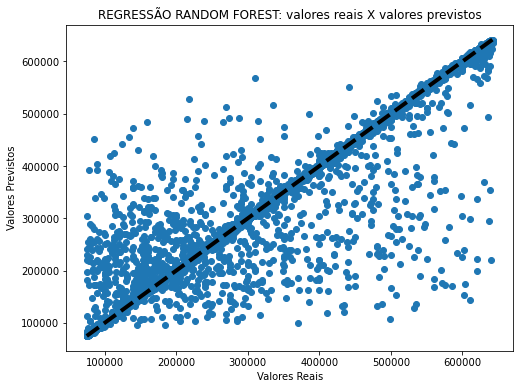

In [23]:
# Plotando valores reais versus valores previstos
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previstos')
plt.title(f'REGRESSÃO RANDOM FOREST: valores reais X valores previstos')
plt.show()

In [24]:
print("valor real: ", y_test[:10].values)
print("valor previsto: ", y_pred[:10])

valor real:  [350000. 186000. 195000. 355000. 208000. 348000. 182500. 350000. 185650.
 260000.]
valor previsto:  [349929.   185992.5  194947.   355069.42 208045.37 347964.62 182372.45
 349999.4  185622.9  259933.  ]


In [25]:
resultado = pd.DataFrame()
resultado[f'REGRESSÃO_RANDOM_FOREST_Previsto'] = y_pred

# Adicionando os valores reais ao DataFrame de resultados
resultado['Real'] = y_test.values

# Salvando em um arquivo CSV
resultado.to_csv('resultados_previsoes.csv', index=False)
resultado.head()

,REGRESSÃO_RANDOM_FOREST_Previsto,Real
0,349929.00,350000.0
1,185992.50,186000.0
2,194947.00,195000.0
3,355069.42,355000.0
4,208045.37,208000.0
